# Advanced Model Architectures
> It's time to get introduced to more advanced architectures! You will create an autoencoder to reconstruct noisy images, visualize convolutional neural network activations, use deep pre-trained models to classify images and learn more about recurrent neural networks and working with text as you build a network that predicts the next word in a sentence. This is the Summary of lecture "Introduction to Deep Learning with Keras", via datacamp.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Tensorflow-Keras, Deep_Learning]
- image: 

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 8)

### Tensors, layers, and autoencoders
- Tensors
    - main data structures used in deep learning.
    - Inputs/Outputs and transformations in neural networks are all presented using tensors
- Autoencoders
![ae](image/ae.png)
    - Use cases
        - Dimensionality reduction:
            - Smaller dimensional space representation of our inputs
        - De-noising data:
            - If trained with clean data, irrelevant noise will be filtered out during reconstruction
        - Anormaly detection
            - A poor reconstruction will result when the model is fed with unseen inputs

### It's a flow of tensors
If you have already built a model, you can use the `model.layers` and the `tf.keras.backend` to build functions that, provided with a valid input tensor, return the corresponding output tensor.

This is a useful tool when we want to obtain the output of a network at an intermediate layer.

For instance, if you get the input and output from the first layer of a network, you can build an `inp_to_out` function that returns the result of carrying out forward propagation through only the first layer for a given input tensor.

So that's what you're going to do right now!

In [2]:
banknote = pd.read_csv('./dataset/banknotes.csv')
banknote.head()

,variace,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
from sklearn.model_selection import train_test_split

X = banknote.drop(['class'], axis=1)
# Normalize data
X = ((X - X.mean()) / X.std()).to_numpy()
y = banknote['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(2, input_shape=(4, ), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 10        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [5]:
import tensorflow.keras.backend as K

# Input tensor from the 1st layer of the model
inp = model.layers[0].input

# Output tensor from the 1st layer of the model
out = model.layers[0].output

# Define a function from inputs to outputs
inp_to_out = K.function([inp], [out])

# Print the results of passing X_test through the 1st layer
print(inp_to_out([X_test]))

[array([[0.        , 0.        ],
       [0.        , 0.        ],
       [1.0797855 , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.22718781, 0.        ],
       [0.        , 1.7850617 ],
       [0.18920442, 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.29243737, 0.        ],
       [1.6578274 , 0.        ],
       [0.18762422, 0.        ],
       [0.5615992 , 0.        ],
       [0.25880906, 0.24804659],
       [0.65603167, 0.        ],
       [0.        , 1.1825007 ],
       [0.        , 0.7996591 ],
       [0.22296531, 0.        ],
       [1.6926856 , 0.        ],
       [0.        , 0.29953033],
       [0.44292253, 3.014936  ],
       [0.        , 0.        ],
       [0.21312332, 0.        ],
       [0.7917944 , 0.39370766],
       [0.05065895, 0.        ],
       [0.10720656, 0.        ],
       [0.        , 1.3967527 ],
       [0.        , 0.45817846],
       [0.38643262, 0.        ],
       [1

### Neural separation
Put on your gloves because you're going to perform brain surgery!

Neurons learn by updating their weights to output values that help them better distinguish between the different output classes in your dataset. You will make use of the `inp_to_out()` function you just built to visualize the output of two neurons in the first layer of the Banknote Authentication `model` as it learns.

In [6]:
def plot():
    fig, axes = plt.subplots(1, 5, figsize=(16, 8))
    for i, a in enumerate(axes):
        a.scatter(layer_outputs[i][:, 0], layer_outputs[i][:, 1], c=y_test, edgecolors='none');
        a.set_title('Test Accuracy: {:3.1f} %'.format(float(test_accuracies[i]) * 100.));
    plt.tight_layout()

In [7]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
layer_outputs = []
test_accuracies = []

for i in range(0, 21):
    # Train model for 1 epoch
    h = model.fit(X_train, y_train, batch_size=16, epochs=1, verbose=0)
    if i % 4 == 0:
        # Get the output of the first layer
        layer_outputs.append(inp_to_out([X_test])[0])
        
        # Evaluate model accuracy for this epoch
        test_accuracies.append(model.evaluate(X_test, y_test)[1])

412/412 [==============================] - 0s 36us/sample - loss: 0.1425 - accuracy: 0.9636


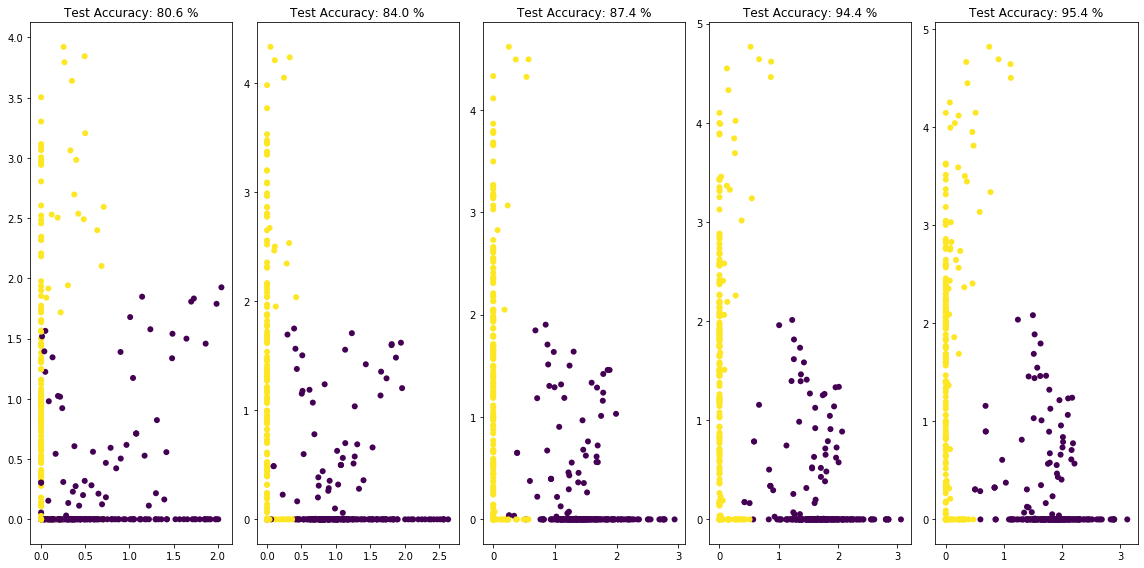

In [9]:
# Plot 1st vs 2nd neuron output
plot()

That took a while! If you take a look at the graphs you can see how the neurons are learning to spread out the inputs based on whether they are fake or legit dollar bills. (A single fake dollar bill is represented as a purple dot in the graph) At the start the outputs are closer to each other, the weights are learned as epochs go by so that fake and legit dollar bills get a different, further and further apart output.

### Building an autoencoder
Autoencoders have several interesting applications like anomaly detection or image denoising. They aim at producing an output identical to its inputs. The input will be compressed into a lower dimensional space, encoded. The model then learns to decode it back to its original form.

You will encode and decode the MNIST dataset of handwritten digits, the hidden layer will encode a 32-dimensional representation of the image, which originally consists of 784 pixels (28 x 28). The autoencoder will essentially learn to turn the 784 pixels original image into a compressed 32 pixels image and learn how to use that encoded representation to bring back the original 784 pixels image.

In [10]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype(np.float32) / 255.
X_test = X_test.astype(np.float32) / 255.
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [11]:
# Start with a sequential model
autoencoder = Sequential(name='autoencoder')

# Add a dense layer with input the original image pixels and neurons the encoded representation
autoencoder.add(Dense(32, input_shape=(784, ), activation='relu'))

# Add an output layer with as many neurons as the original image pixels
autoencoder.add(Dense(784, activation='sigmoid'))

# Compile your model with adadelta
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# Summarize your model structure
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_3 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


### De-noising like an autoencoder
Okay, you have just built an `autoencoder` model. Let's see how it handles a more challenging task.

First, you will build a model that encodes images, and you will check how different digits are represented with `show_encodings()`. To build the encoder you will make use of your autoencoder, that has already being trained. You will just use the first half of the network, which contains the input and the bottleneck output. That way, you will obtain a 32 number output which represents the encoded version of the input image.

Then, you will apply your autoencoder to noisy images from MNIST, it should be able to clean the noisy artifacts.

The digits in this noisy dataset look like this:
![noise](image/noisy_mnist_sample.png)

In [12]:
def show_encodings(encoded_imgs,number=1):
    n = 5  # how many digits we will display
    original = X_test
    original = original[np.where(y_test == number)]
    encoded_imgs = encoded_imgs[np.where(y_test==number)]
    plt.figure(figsize=(20, 4))
    #plt.title('Original '+str(number)+' vs Encoded representation')
    for i in range(min(n,len(original))):
        # display original imgs
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display encoded imgs
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.tile(encoded_imgs[i],(32,1)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

def compare_plot(original,decoded_imgs):
    n = 4  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.title('Noisy vs Decoded images')

In [18]:
# Train autoencoder
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test));

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 8us/sample - loss: 0.6870 - val_loss: 0.6868
Epoch 2/50
60000/60000 [==============================] - 0s 8us/sample - loss: 0.6868 - val_loss: 0.6866
Epoch 3/50
60000/60000 [==============================] - 0s 8us/sample - loss: 0.6865 - val_loss: 0.6864
Epoch 4/50
60000/60000 [==============================] - 0s 8us/sample - loss: 0.6863 - val_loss: 0.6861
Epoch 5/50
60000/60000 [==============================] - 0s 8us/sample - loss: 0.6861 - val_loss: 0.6859
Epoch 6/50
60000/60000 [==============================] - 0s 8us/sample - loss: 0.6858 - val_loss: 0.6857
Epoch 7/50
60000/60000 [==============================] - 0s 8us/sample - loss: 0.6856 - val_loss: 0.6854
Epoch 8/50
60000/60000 [==============================] - 0s 8us/sample - loss: 0.6854 - val_loss: 0.6852
Epoch 9/50
60000/60000 [==============================] - 0s 8us/sample - loss: 0.6851 - val_loss: 0.6

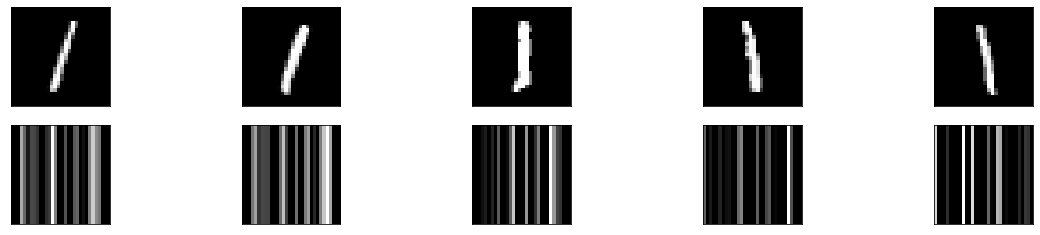

In [19]:
# Build your encoder by using the first layer of your autoencoder
input_img = tf.keras.layers.Input(shape=(784, ))
encoded = Dense(32, activation='relu')(input_img)
encoder = tf.keras.models.Model(input_img, encoded)
# encoder.add(autoencoder.layers[0])

# Encode the noisy images and show the encodings for your favorite number [0-9]
encodings = encoder.predict(X_test)
# encodings
show_encodings(encodings, number=1)

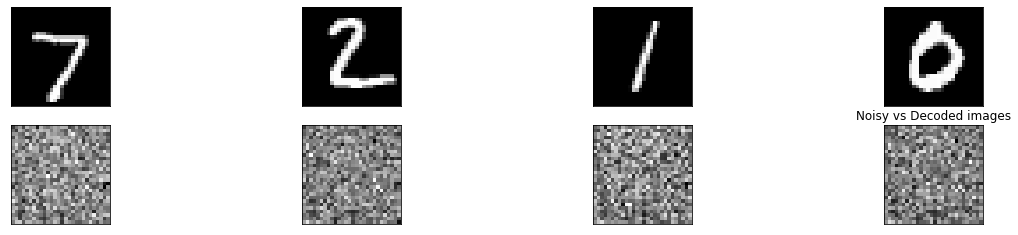

In [17]:
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model()

# Predict on the noisy images with your autoencoder
decoded_imgs = autoencoder.predict(X_test)

# Plot noisy vs decoded images
compare_plot(X_test, decoded_imgs)

Amazing! The noise is gone now! You could get a better reconstruction by using a convolutional autoencoder. I hope this new model opened up your mind to the many possible architectures and non-classical ML problems that neural networks can solve :)

In [20]:
# this is the siez of our encoded representations
ENCODING_DIM = 32

# input placeholder
input_img = tf.keras.layers.Input(shape=(784,))

# this is the encoded representation of the input
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu')(input_img)

# this is the loss reconstruction of the input
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its recommendation
autoencoder = tf.keras.models.Model(input_img, decoded)

In [21]:
# let's also create a seprate encoder model
# this mode maps an input to its encoded representation
encoder = tf.keras.models.Model(input_img, encoded)